# Loading in the Data

Downloading the dataset from Kaggle and creating a Pandas dataframe.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.optimizers import Adam
from getpass import getpass
from sklearn.preprocessing import MinMaxScaler


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# 1-1 Processing

In [2]:
user = getpass('Kaggle Username: ')
key = getpass('Kaggle API key: ')
# You need to provide your Kaggle username and API key
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

Kaggle Username: ··········
Kaggle API key: ··········


In [3]:
!mkdir -p electricity_data
!kaggle datasets download -d robikscube/hourly-energy-consumption -p electricity_data

 79% 9.00M/11.4M [00:00<00:00, 24.7MB/s]
100% 11.4M/11.4M [00:00<00:00, 28.9MB/s]


In [4]:
!kaggle datasets files robikscube/hourly-energy-consumption

name                  size  creationDate         
-------------------  -----  -------------------  
PJM_Load_hourly.csv  900KB  2018-08-30 14:17:03  
FE_hourly.csv          2MB  2018-08-30 14:17:03  
DOM_hourly.csv         3MB  2018-08-30 14:17:03  
AEP_hourly.csv         3MB  2018-08-30 14:17:03  
COMED_hourly.csv       2MB  2018-08-30 14:17:03  
NI_hourly.csv          2MB  2018-08-30 14:17:03  
pjm_hourly_est.csv    12MB  2018-08-30 14:17:03  
DUQ_hourly.csv         3MB  2018-08-30 14:17:03  
PJMW_hourly.csv        4MB  2018-08-30 14:17:03  
DEOK_hourly.csv        1MB  2018-08-30 14:17:03  
EKPC_hourly.csv        1MB  2018-08-30 14:17:03  
PJME_hourly.csv        4MB  2018-08-30 14:17:03  
est_hourly.paruqet     4MB  2018-08-30 14:17:03  
DAYTON_hourly.csv      3MB  2018-08-30 14:17:03  


In [5]:
!unzip -o -q electricity_data/hourly-energy-consumption.zip
df = pd.read_csv('DAYTON_hourly.csv')
df.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   121275 non-null  object 
 1   DAYTON_MW  121275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
df.tail()

,Datetime,DAYTON_MW
121270,2018-01-01 20:00:00,2732.0
121271,2018-01-01 21:00:00,2724.0
121272,2018-01-01 22:00:00,2664.0
121273,2018-01-01 23:00:00,2614.0
121274,2018-01-02 00:00:00,2552.0


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'],errors='coerce')
df['DAYTON_MW'] = pd.to_numeric(df['DAYTON_MW'],errors='coerce')
df = df.dropna()

In [ ]:
df['DAYTON_MW'].describe()

count    121275.000000
mean       2037.851140
std         393.403153
min         982.000000
25%        1749.000000
50%        2009.000000
75%        2279.000000
max        3746.000000
Name: DAYTON_MW, dtype: float64

In [ ]:
df.info()
df = df.set_index('Datetime')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datetime   121275 non-null  datetime64[ns]
 1   DAYTON_MW  121275 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 MB


In [ ]:
hours_in_future = 24

In [ ]:
labels = df[['DAYTON_MW']].shift(-1 * hours_in_future)
labels.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1713.0
2004-12-31 02:00:00,1647.0
2004-12-31 03:00:00,1611.0
2004-12-31 04:00:00,1608.0
2004-12-31 05:00:00,1630.0


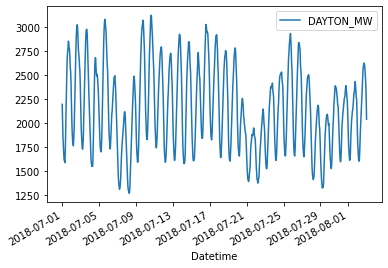

In [ ]:
df[df.index >= '2018-07-01'].plot()

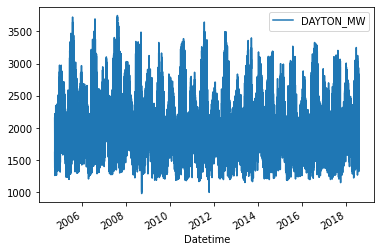

In [ ]:
df.plot()

In [ ]:
X = df.values[0:-1 * hours_in_future]
y = labels.values[0: - 1 * hours_in_future]
print(X.shape, y.shape)

(121251, 1) (121251, 1)


In [ ]:
X[0]
y[0]

array([1713.])

In [ ]:
import math
test_proportion = 0.15
num_examples = X.shape[0]
num_test_examples = math.ceil(test_proportion * num_examples)
X_train = X[0:-1 * num_test_examples, :]
y_train = y[0:-1 * num_test_examples, :]
X_test = X[-1 * num_test_examples:, :]
y_test = y[-1 * num_test_examples:, :]

In [ ]:
# Rescale the X and y values. Note that these must be rescaled separately 
# because the dimensions are different.
rescaler = MinMaxScaler()
X_train_rescaled = rescaler.fit_transform(X_train)
X_test_rescaled = rescaler.transform(X_test)
y_rescaler = MinMaxScaler()
y_train_rescaled = y_rescaler.fit_transform(y_train)
y_test_rescaled = y_rescaler.transform(y_test)

# Check rescaling
print(np.min(X_train_rescaled), np.max(X_train_rescaled))
print(np.min(X_test_rescaled), np.max(X_test_rescaled))
print(np.min(y_train_rescaled), np.max(y_train_rescaled))

0.0 1.0
0.06114327062228658 0.8201881331403762
0.0 1.0


In [ ]:
num_past = 10*24

In [ ]:
X_train.shape

(103063, 1)

In [ ]:
def batch_for_keras(X_data, y_data, seq_length):
  num_examples = X_data.shape[0] - seq_length
  print(num_examples)
  X_res = np.zeros((num_examples, seq_length, X_data.shape[1]))
  y_res = np.zeros((num_examples, y_data.shape[1]))
  for i in range(num_examples):
    X_res[i, :, :] = X_data[i : i + seq_length, :]
    y_res[i,:] = y_data[i + seq_length, :]
  return (X_res, y_res)

In [ ]:
X_train_keras, y_train_keras = batch_for_keras(X_train_rescaled, y_train_rescaled, num_past)

102823


In [ ]:
X_train_keras.shape

(102823, 240, 1)

In [ ]:
X_train_keras[0].shape

(240, 1)

In [ ]:
y_train_keras.shape

(102823, 1)

In [ ]:
X_train_linreg = X_train_keras.reshape((X_train_keras.shape[0], X_train_keras.shape[1]))
y_train_linreg = y_train_keras.reshape((X_train_keras.shape[0]))

1. Implement predictor: predict last entry of that vector. Manually compute the squared loss (MSE)

2. Implement linear regression "autoregressive model" -> LinearRegression()

3. Implement SimpleRNN

In [ ]:
print(X_train.shape)
print(y_train.shape)

(103063, 1)
(103063, 1)


In [ ]:
len_predictions = 240

mse = np.zeros(len(X_test))
predictions = np.zeros(len(X_test))
labels = np.zeros(len(X_test))
for i in range(len(X_test)):
  mse[i] = ((y_test[i] - X_test[i]) ** 2)
  predictions[i] = X_test[i]
  labels[i] = y_test[i]

print(mse.mean())

# check to see if there is an offset by 1

47093.03177919507


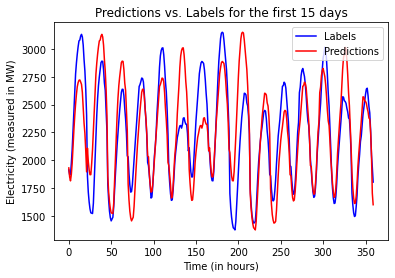

In [ ]:
first_15_predictions = np.zeros(360)
first_15_labels = np.zeros(360)
for i in range(360):
  first_15_predictions[i] = predictions[i]
  first_15_labels[i] = labels[i]

plt.plot(first_15_labels, color='blue', label='Labels')
plt.plot(first_15_predictions, color='red', label='Predictions')
plt.title('Predictions vs. Labels for the first 15 days')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (measured in MW)')
plt.legend()

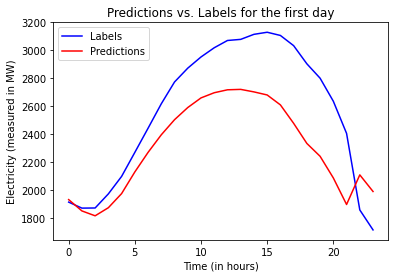

In [ ]:
first_day_predictions = np.zeros(24)
first_day_labels = np.zeros(24)
for i in range(24):
  first_day_predictions[i] = predictions[i]
  first_day_labels[i] = labels[i]

plt.plot(first_day_labels, color='blue', label='Labels')
plt.plot(first_day_predictions, color='red', label='Predictions')
plt.title('Predictions vs. Labels for the first day')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (measured in MW)')
plt.legend()

In [ ]:
predictions.shape
baseline_predictions = predictions.copy()

In [ ]:
# 2: implement linear regression
from sklearn import linear_model
model = linear_model.LinearRegression()

In [ ]:
model.fit(X_train_linreg, y_train_linreg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
X_test_linreg, y_test_linreg = batch_for_keras(X_test_rescaled, y_test_rescaled, num_past)
X_test_linreg = X_test_linreg.reshape((X_test_linreg.shape[0], X_test_linreg.shape[1]))
y_test_linreg = y_test_linreg.reshape((X_test_linreg.shape[0]))

17948


In [ ]:
preds = model.predict(X_test_linreg)

In [ ]:
mse_2 = np.zeros(len(preds))
for i in range(len(preds)):
  mse_2[i] = ((y_test_linreg[i] - preds[i]) ** 2)
mse_2.mean()

0.0035626082580172006

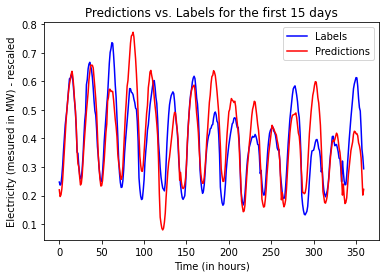

In [ ]:
first_year_predictions = np.zeros(360)
first_year_labels = np.zeros(360)
for i in range(360):
  first_year_predictions[i] = preds[i]
  first_year_labels[i] = y_test_linreg[i]

plt.plot(first_year_labels, color='blue', label='Labels')
plt.plot(first_year_predictions, color='red', label='Predictions')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (mesured in MW) - rescaled')
plt.title('Predictions vs. Labels for the first 15 days')
plt.legend()

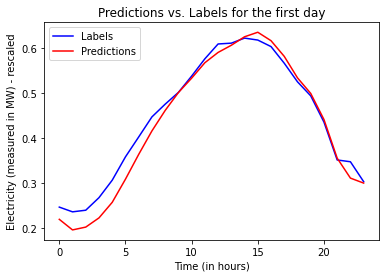

In [ ]:
first_month_predictions = np.zeros(24)
first_month_labels = np.zeros(24)
for i in range(24):
  first_month_predictions[i] = preds[i]
  first_month_labels[i] = y_test_linreg[i]

plt.plot(first_month_labels, color='blue', label='Labels')
plt.plot(first_month_predictions, color='red', label='Predictions')
plt.title('Predictions vs. Labels for the first day')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (measured in MW) - rescaled')
plt.legend()

In [ ]:
# create a validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_keras, y_train_keras, test_size=0.2)

# implement SimpleRNN
import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Activation, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# model creation
model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(240, 1)))
model.add(Dense(25, activation=None))
model.add(Dense(10, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='Adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 11,946
Trainable params: 11,946
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
2571/2571 [==============================] - 28s 11ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 2/25
2571/2571 [==============================] - 27s 11ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 3/25
2571/2571 [==============================] - 27s 11ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 4/25
2571/2571 [==============================] - 27s 11ms/step - loss: 0.0031 - val_loss: 0.0030


In [ ]:
X_test_keras, y_test_keras = batch_for_keras(X_test_rescaled, y_test_rescaled, num_past)

17948


In [ ]:
predictions = model.predict(X_test_keras)

In [ ]:
model.evaluate(X_test_keras, y_test_keras)

561/561 [==============================] - 3s 5ms/step - loss: 0.0028


0.0027996734715998173

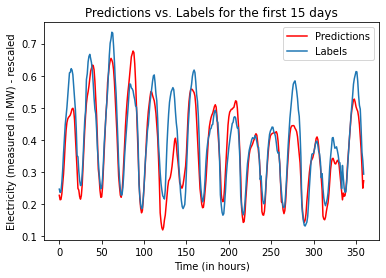

In [ ]:
pred_100 = np.zeros(360)
labels_100 = np.zeros(360)
for i in range(360):
  pred_100[i] = predictions[i]
  labels_100[i] = y_test_keras[i]
plt.plot(pred_100, color='red', label='Predictions')
plt.plot(labels_100, label='Labels')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (measured in MW) - rescaled')
plt.title('Predictions vs. Labels for the first 15 days')
plt.legend()

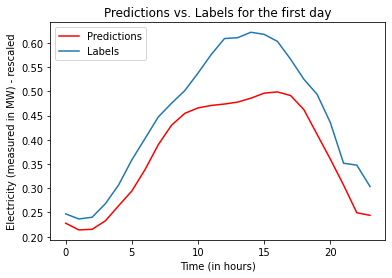

In [ ]:
pred_100 = np.zeros(24)
labels_100 = np.zeros(24)
for i in range(24):
  pred_100[i] = predictions[i]
  labels_100[i] = y_test_keras[i]
plt.plot(pred_100, color='red', label='Predictions')
plt.plot(labels_100, label='Labels')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (measured in MW) - rescaled')
plt.title('Predictions vs. Labels for the first day')
plt.legend()

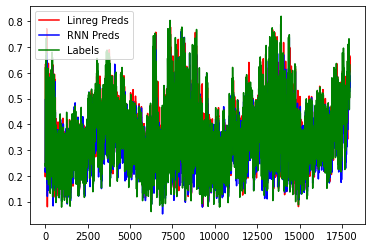

In [ ]:
plt.plot(preds, color='red', label='Linreg Preds')
plt.plot(predictions, color='blue', label='RNN Preds')
plt.plot(y_test_keras, color='green', label='Labels')
plt.legend()

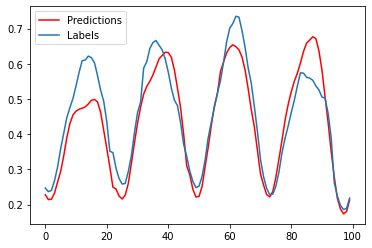

In [ ]:
pred_100 = np.zeros(100)
labels_100 = np.zeros(100)
for i in range(100):
  pred_100[i] = predictions[i]
  labels_100[i] = y_test_keras[i]
plt.plot(pred_100, color='red', label='Predictions')
plt.plot(labels_100, label='Labels')
plt.legend()

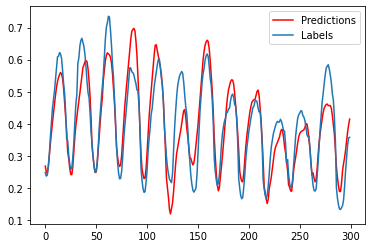

In [ ]:
plt.plot(predictions[0:300], color='red', label='Predictions')
plt.plot(y_test_keras[0:300], label='Labels')
plt.legend()

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

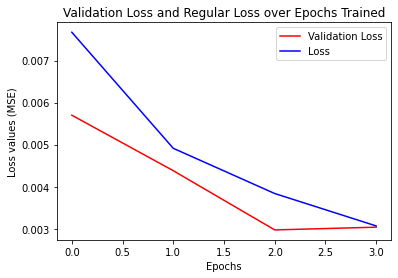

In [ ]:
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.plot(history.history['loss'], color='blue', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss values (MSE)')
plt.title('Validation Loss and Regular Loss over Epochs Trained')
plt.legend()

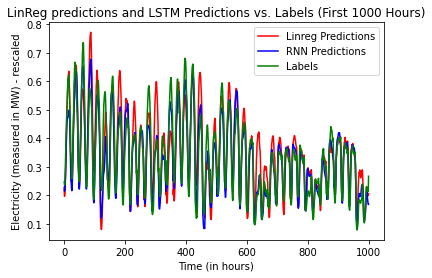

In [ ]:
plt.plot(preds[:1000], color='red', label='Linreg Predictions')
plt.plot(predictions[:1000], color='blue', label='RNN Predictions')
plt.plot(y_test_keras[:1000], color='green', label='Labels')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (measured in MW) - rescaled')
plt.title('LinReg predictions and LSTM Predictions vs. Labels (First 1000 Hours)')
plt.legend()

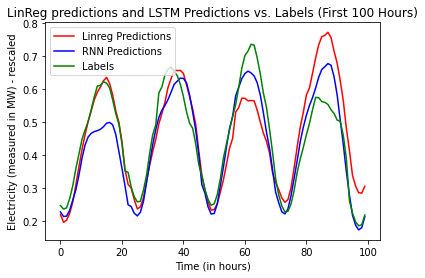

In [ ]:
# Zoomed-in version
plt.plot(preds[:100], color='red', label='Linreg Predictions')
plt.plot(predictions[:100], color='blue', label='RNN Predictions')
plt.plot(y_test_keras[:100], color='green', label='Labels')
plt.xlabel('Time (in hours)')
plt.ylabel('Electricity (measured in MW) - rescaled')
plt.title('LinReg predictions and LSTM Predictions vs. Labels (First 100 Hours)')
plt.legend()

In [ ]:
# 1. Fix the missing graph
# 2. Add all model predictions + labels on a single graph + include a zoomed-in version
# 3. Reporting + computing MAPE
# 4. Plot of val loss vs. epoch for RNN
# 5. Change RNN: SimpleRNN -> LSTM, increase the dimension of the hidden layers (5, 1). Train for many epochs model.fit save history -> history to plot 
# 6. try the 3-day-ahead prediction task + compare results
# 7. Add legends to the graphs plt.legend()
# 8. Make sure all final plots are on the test


# [OLD] Data Pre-processing


Goals:


1.   Add an "id" column
2.   Change datetime to python datetime
3.   Check to make sure the two columns ('Datetime' and 'DAYTON_MW') are clean





In [ ]:
# Goal 1
df['id'] = np.arange(1, len(df) + 1)
df.head()

,DAYTON_MW,id
Datetime,,
2004-12-31 01:00:00,1596.0,1
2004-12-31 02:00:00,1517.0,2
2004-12-31 03:00:00,1486.0,3
2004-12-31 04:00:00,1469.0,4
2004-12-31 05:00:00,1472.0,5


In [ ]:
# Goal 2
from datetime import timedelta

start_date = df[df['id'] == 1]['Datetime']
end_date = df[df['id'] == (len(df) + 1)]['Datetime']

pred_steps = 14
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(start_date)
last_day = pd.to_datetime(end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

KeyError: ignored

In [ ]:
# data is clean - no null values
print(df[df['Datetime'].isnull()])
print(df[df['DAYTON_MW'].isnull()])

In [ ]:
# No negative values or values that are too high
df['DAYTON_MW'].describe()

In [ ]:
# Hourly measurements are taken: starting at 1 AM on Dec 31 2004, ending on Jan 2 2018 at midnight
# Very clean dataset
df['Datetime'].describe()

# [OLD] Data Exploration

Creating graphs to visualize and further understand the data.

In [ ]:
df['DAYTON_MW'].plot.hist()

It looks like the average megawatt reading is around 2000 MW.

In [ ]:
test_df = df.loc[df['DAYTON_MW'] < 1200]
sns.relplot(x='Datetime', y='DAYTON_MW', data=test_df)

This graph shows that as time goes on, people use more and more electricity (then again, this is only a small sample of all the readings: < 1200 MW).

In [ ]:
test_df2 = df.loc[df['DAYTON_MW'] > 3400]
sns.relplot(x='Datetime', y='DAYTON_MW', data=test_df2)

The above graph doesn't show the same pattern that the previous graph showed. In this one, the MW readings are all spread out.

# To be done



1.   Create train_test split
2.   Implement simple ML algorithm, analyze the results.

